# Persistent homology for smartphone data analysis (pedestrian recognition)

__Description__: The goal of this is project to illustrate, on a toy example, the benefit of “coordinate in- variance” of persistent homology. The walk of 3 pedestrians A, B and C, has been recorded using the accelerometer sensor of a smartphone carried in the their pocket, giving rise to 3 multivariate time series in R3: each time series represents the 3 coordinates of the acceleration of the corresponding pedestrian in a coordinate system attached to the sensor. As, the smartphone was carried in unknown different positions and was not fixed, these time series cannot be compared coordinates by coordinates. Using a sliding window, each series has been splitted in a list of 100 times series made of 200 consecutive points, that are stored in data A, data B and data C. To each set of 200 points is associated a label A, B or C stored in label (see the data set and the Python script to load the data). The objective is to compute the persistence diagrams of these 3D point clouds and use them to achieve a pedestrian recognition task (supervised setting).
Note: This project requires some (basic) knowledge of learning (random forests).

In [1]:
import numpy as np
import pickle as pickle
from os.path import join
import matplotlib.pyplot as plt
%matplotlib inline

## Question 1: Loading Data

In [6]:
path="C:\\Users\\cloti\\Desktop\\MSc in Data Science\\T1 2017\\Geometric Methods\\Final Project\\PersistentHomology\\data_acc_rot.dat"

In [7]:
f = open(path,"rb")
data = pickle.load(f,encoding='latin1')
f.close()

data_A = data[0]
data_B = data[1] 
data_C = data[2]
label = data[3]

## Question 2:

Compute and save the 0-dimensional and 1-dimensional persistence diagrams of the Rips filtrations (or alternately the alpha-shape filtrations) built on top of each of the 300 point clouds in R3.

In [8]:
import gudhi

## About persistent homology 

### General definitions
Let (P, D) be a metric space where P is a point set. 
Given r > 0, the Rips complex is the simplicial complex R(P) constituted by the simplexes such that$d(p,q) \leq r$ for every pair of vertices in the simplex.  
Constructing the Rips complex helps capture the topology of the data set. Choosing $r$ is a difficult task because if $r$ ois too small, the complex is a discrete set, and if $r$ is too large, the complex becomes a single high-dimensional complex.


Given a filtration $(K_0, K_1, ..., K_n)$, the $p$-dimensional persistence diagram is the set of points (i,j) such that the number of $p$-dimensional homology classes born at $K_i$ that die entering $K_j$ is one.  
Here the filtration will actually be a sequence of Rips complexes associated to the 3D point cloud for an increasing
sequence of parameter values ($r_i$).


### 0-dimensional persistence diagrams of the Rips filtrations

In order to draw the 0-dimensional persistence diagram of the Rips filtrations, we use \verb gudhi.RipsComplex on the 3D point cloud. 

> __parameter to tune is the maxEdgeLen__

In [29]:
def build_0_persistent_diag(dataset, maxEdgeLen=10):
    persist=[]
    for i in range(len(dataset)):
        rips = gudhi.RipsComplex(points=dataset[i],max_edge_length=maxEdgeLen)
        simplex_tree = rips.create_simplex_tree(max_dimension=1)
        diag = simplex_tree.persistence()
        persist.append(diag)
    return persist

> Compute the 0 persistent diagram for the 3 pedestrians 

In [30]:
diagA_0=build_0_persistent_diag(data_A)
diagB_0=build_0_persistent_diag(data_B)
diagC_0=build_0_persistent_diag(data_C)

### 1-dimensional persistence diagrams of the Rips filtrations

In [28]:
def build_1_persistent_diag(dataset, maxEdgeLen=100):
    persist=[]
    for i in range(len(dataset)):
        rips = gudhi.RipsComplex(points=dataset[i],max_edge_length=maxEdgeLen)
        simplex_tree = rips.create_simplex_tree(max_dimension=2)
        diag = simplex_tree.persistence()
        persist.append(diag)
    return persist

> Compute the 1 persistent diagram for the 3 pedestrians 

In [12]:
diagA_1=build_1_persistent_diag(data_A)
diagB_1=build_1_persistent_diag(data_B)
diagC_1=build_1_persistent_diag(data_C)

## Question 3: Matrices of pairwise bottleneck distances between diagrams and use a dimensionality reduction algorithm to visualize them in 2D and 3D (e.g. Multidimensional Scaling).


The bottleneck distance measures the similarity between two persistence diagrams. It is the shortest distance $d$ for which there exists a perfect matching between the points of the two diagrams such that any couple of matched points are at distance at most $d$. The cost of matching, i.e. taking a point $p$ of the first diagram to a point $p'$ of the second diagram corresponds the minimum between moving $p$ to $p'$ and moving both points on the diagonal.

USE Gudhi::persistence_diagram::bottleneck_distance (const Persistence_diagram1 &diag1, const Persistence_diagram2 &diag2, double e=(std::numeric_limits< double >::min)())

Why are we comparing 0 and 1-dimensional persistence diagrams of the Rips filtrations ? 

BLABLABLABLA

USE sklearn.manifold.MDS for multidimensional scaling. 

remarques du cours
→ Vietoris-Rips (or Cech, witness) filtrations quickly become prohibitively large as
the size of the data increases ( O(|X|
d
) ), making the computation of persistence
practically almost impossible.
→ Persistence diagrams of Rips-Vietoris (and Cˇech, witness,..) filtrations and
Gromov-Hausdorff distance are very sensitive to noise and outliers

### Pair of (birth , death) tuple

In [13]:
def buildPair(diagram):
    return [item[1] for item in diagram] 

> with 0-persitent diagram

In [31]:
diagA_0_pairs=[buildPair(diag) for diag in diagA_0] 
diagB_0_pairs=[buildPair(diag) for diag in diagB_0] 
diagC_0_pairs=[buildPair(diag) for diag in diagC_0] 

> with 1-persitent diagram

In [15]:
diagA_1_pairs=[buildPair(diag) for diag in diagA_1] 
diagB_1_pairs=[buildPair(diag) for diag in diagB_1] 
diagC_1_pairs=[buildPair(diag) for diag in diagC_1]

- The function below compute the bootleneck distance between two persistent diagrams

In [32]:
from sklearn import manifold

In [33]:
def computeMatrixBottleneckDistance(diagList1):
    matrix=np.zeros((len(diagList1),len(diagList1)))
    for i in range(len(diagList1)):
        for j in range(i,len(diagList1)):
            dist=gudhi.bottleneck_distance(diagList1[i], diagList1[j], 0.001)
            matrix[i,j]=dist
            matrix[j,i]=dist
    return matrix

> with 0-persitent diagram

In [34]:
matrix_bottleneck_distance_A_0=computeMatrixBottleneckDistance(diagA_0_pairs)
matrix_bottleneck_distance_B_0=computeMatrixBottleneckDistance(diagB_0_pairs)
matrix_bottleneck_distance_C_0=computeMatrixBottleneckDistance(diagC_0_pairs)

> with 1-persitent diagram

In [19]:
matrix_bottleneck_distance_A_1=computeMatrixBottleneckDistance(diagA_1_pairs)
matrix_bottleneck_distance_B_1=computeMatrixBottleneckDistance(diagB_1_pairs)
matrix_bottleneck_distance_C_1=computeMatrixBottleneckDistance(diagC_1_pairs)


> ## With 0-persistent homology

### Pedestrian A,B and C

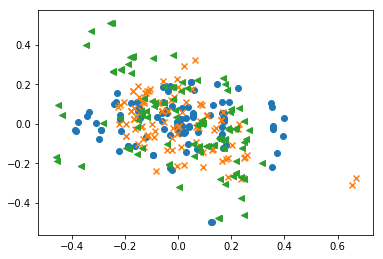

In [35]:
mds2 = manifold.MDS(n_components=2, max_iter=3000, eps=1e-9,
                   dissimilarity="precomputed", n_jobs=1)
posA = mds2.fit(matrix_bottleneck_distance_A_0).embedding_
posB = mds2.fit(matrix_bottleneck_distance_B_0).embedding_
posC = mds2.fit(matrix_bottleneck_distance_C_0).embedding_

plt.subplots_adjust(bottom = 0.1)
plt.scatter(
    posA[:, 0], posA[:, 1], marker = 'o'
    )
plt.scatter(
    posB[:, 0], posB[:, 1], marker = 'x'
    )
plt.scatter(
    posC[:, 0], posC[:, 1], marker = '<'
    )
plt.show()

> ## With 1-persistent homology

### Pedestrian A,B and C

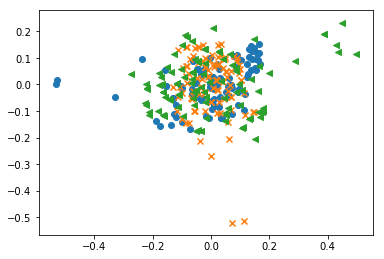

In [30]:
mds2 = manifold.MDS(n_components=2, max_iter=3000, eps=1e-9,
                   dissimilarity="precomputed", n_jobs=1)
posA = mds2.fit(matrix_bottleneck_distance_A_1).embedding_
posB = mds2.fit(matrix_bottleneck_distance_B_1).embedding_
posC = mds2.fit(matrix_bottleneck_distance_C_1).embedding_

plt.subplots_adjust(bottom = 0.1)
plt.scatter(
    posA[:, 0], posA[:, 1], marker = 'o'
    )
plt.scatter(
    posB[:, 0], posB[:, 1], marker = 'x'
    )
plt.scatter(
    posC[:, 0], posC[:, 1], marker = '<'
    )
plt.show()

# With 0-persistent homology, 3D

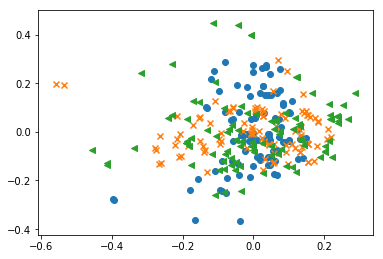

In [27]:
mds2 = manifold.MDS(n_components=3, max_iter=3000, eps=1e-9,
                   dissimilarity="precomputed", n_jobs=1)
posA = mds2.fit(matrix_bottleneck_distance_A_0).embedding_
posB = mds2.fit(matrix_bottleneck_distance_B_0).embedding_
posC = mds2.fit(matrix_bottleneck_distance_C_0).embedding_

plt.subplots_adjust(bottom = 0.1)
plt.scatter(
    posA[:, 0], posA[:, 1], marker = 'o'
    )
plt.scatter(
    posB[:, 0], posB[:, 1], marker = 'x'
    )
plt.scatter(
    posC[:, 0], posC[:, 1], marker = '<'
    )
plt.show()

# With 1-persistent homology, 3D

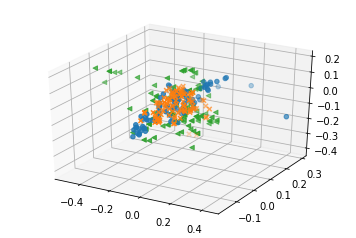

In [39]:
from mpl_toolkits.mplot3d import Axes3D

mds2 = manifold.MDS(n_components=3, max_iter=3000, eps=1e-9,
                   dissimilarity="precomputed", n_jobs=1)
posA = mds2.fit(matrix_bottleneck_distance_A_1).embedding_
posB = mds2.fit(matrix_bottleneck_distance_B_1).embedding_
posC = mds2.fit(matrix_bottleneck_distance_C_1).embedding_

plt.subplots_adjust(bottom = 0.1)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(
    posA[:, 0], posA[:, 1], posA[:, 2], marker = 'o'
    )
ax.scatter(
    posB[:, 0], posB[:, 1], posB[:, 2], marker = 'x'
    )
ax.scatter(
    posC[:, 0], posC[:, 1], posC[:, 2], marker = '<'
    )
plt.show()

## Question 4: Computing persistence landscape
This function should take as input a persistence
diagram dgm (in the Gudhi format), a dimension k, the endpoints xmin, xmax of an interval, the
number nb_nodes of nodes of a regular grid on the interval [xmin, xmax] and a number of landscapes
nb_ld, and output a nbld × nbnodes array storing the values of the first nb_ld landscapes of dgm on the
node of the grid. Check, on some simple examples that your code is correct.

In [31]:
def computeLandscapes(dgm,x_min,x_max,nb_nodes,nb_lbd):
    ''' This function compute the approximate landscape of a persistent diagram. 
    Given a range [xmin,xmax] and a grid size '''
    
    output = np.zeros((nb_lbd,nb_nodes))
    step = (x_max - x_min) / nb_nodes
    for i in range(nb_nodes):
        x = x_min + i * step
        event_list = []
        for tup in dgm:
            b = tup[0]
            d = tup[1]
            if (b <= x) and (x<= d):
                if x >= (d+b)/2. :
                    event_list.append((d-x))
                else:
                    event_list.append((x-b))
        event_list.sort(reverse=True)
        event_list = np.asarray(event_list)
        for j in range(nb_lbd):
            if(j<len(event_list)):
                output[j,i]=event_list[j]
    return output

> Example

In [32]:
diagA_1_pair_test= [diagA_1[0][a][1] for a in range(len(diagA_1[0]))] 
computeLandscapes(diagA_1_pair_test,0,15,400,5)

array([[ 0.    ,  0.0375,  0.075 , ..., 14.8875, 14.925 , 14.9625],
       [ 0.    ,  0.0375,  0.075 , ...,  0.    ,  0.    ,  0.    ],
       [ 0.    ,  0.0375,  0.075 , ...,  0.    ,  0.    ,  0.    ],
       [ 0.    ,  0.0375,  0.075 , ...,  0.    ,  0.    ,  0.    ],
       [ 0.    ,  0.0375,  0.075 , ...,  0.    ,  0.    ,  0.    ]])

### For each 0-dimensional and 1-dimensional persistence diagrams, compute the first 5 landscapes on a
relevant interval with a few hundred of nodes. Splitting randomly the data set into a 80/20 learning/test
data, use a random forest to explore the performances of the 0-dimensional or 1-dimensional landscapes
to classify pedestrians. An example of code to realize such an experiment can be downloaded at http:
//geometrica.saclay.inria.fr/team/Fred.Chazal/Centrale2017.html. Compare the results you
obtain using 0-dimensional landscapes, 1-dimensional landscapes or both.



> Set parameter for the landscape approximation computation

In [33]:
x_min=0
x_max=5
nb_nodes=300
nb_lbd=5

> with 0-persitent diagram

In [34]:
diagA_0_landscapes=[computeLandscapes(pair,x_min,x_max,nb_nodes,nb_lbd) for pair in diagA_0_pairs]
diagB_0_landscapes=[computeLandscapes(pair,x_min,x_max,nb_nodes,nb_lbd) for pair in diagB_0_pairs]
diagA_0_landscapes=[computeLandscapes(pair,x_min,x_max,nb_nodes,nb_lbd) for pair in diagC_0_pairs]

> with 1-persitent diagram

In [35]:
diagA_1_landscapes=[computeLandscapes(pair,x_min,x_max,nb_nodes,nb_lbd) for pair in diagA_1_pairs]
diagB_1_landscapes=[computeLandscapes(pair,x_min,x_max,nb_nodes,nb_lbd) for pair in diagB_1_pairs]
diagA_1_landscapes=[computeLandscapes(pair,x_min,x_max,nb_nodes,nb_lbd) for pair in diagC_1_pairs]

### Do the same experiment as previously, but using the raw data ( 3 × 200 array of acceleration coordinates).
Compare the obtained classification results to the previous one.

## Random Forest

In [36]:
# Define a scoring fonction to evaluate modelling
from sklearn.cross_validation import cross_val_score

def compute_score(clf, X, y, scoring='accuracy'):
    xval = cross_val_score(clf, X, y, cv = 5, scoring=scoring)
    return mean(xval)

/Users/yaguethiam/anaconda/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [37]:
### Use GridSearchCV to tune parameters for Random Forest
# turn run_gs to True if you want to run the gridsearch again.
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import StratifiedKFold
from sklearn.grid_search import GridSearchCV


run_gs = False

if run_gs:
    parameter_grid = {
                 'max_depth' : [4, 6, 8, None],
                 'n_estimators': [10, 20, 50, 100],
                 'max_features': ['sqrt', 'auto', 'log2'],
                 'min_samples_split': [1, 3, 10,30, 50],
                 'min_samples_leaf': [1, 3, 10, 30, 50],
                 'bootstrap': [True, False],
                 'criterion': ['gini', 'entropy']
                 }
    rf = RandomForestClassifier()
    cross_validation = StratifiedKFold(targets, n_folds=5)

    grid_search = GridSearchCV(rf,
                               scoring='accuracy',
                               param_grid=parameter_grid,
                               cv=cross_validation)
    # Input the label of the training set and the related targets
    grid_search.fit(train, targets)
    rf_best = grid_search
    parameters = grid_search.best_params_

    print('Best score: {}'.format(grid_search.best_score_))
    print('Best parameters: {}'.format(grid_search.best_params_))
else: 
    parameters = {'bootstrap': False, 'min_samples_leaf': 3, 'n_estimators': 50, 
                  'min_samples_split': 10, 'max_features': 'sqrt', 'max_depth': 6}
    # **parameters enables to retrieve the optimal parameters derived from GridSearchCV
    rf_best = RandomForestClassifier(**parameters)
    
    # Again, input the correct names for the training set and its related target variables
    rf_best.fit(train, targets)
    
compute_score(rf_best, train, targets, scoring='accuracy')

/Users/yaguethiam/anaconda/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


NameError: name 'train' is not defined

> Teacher's random forest

In [ ]:
# -*- coding: utf-8 -*-
"""
Created on Sun Dec 17 18:33:31 2017

@author: Fredreci Chazal - All rights reserved
"""
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

#### Classification with random forests 
#### Interesting compare with L0_list, L1_list and L_list
#### where L0_list, L1_list and L_list are list storing the $0$-dimensional 
#### landscapes, $1$-dimensional landscapes, and the concatenation of both 
#### respectively
avg = 0
for i in range(20):
    L_train, L_test, label_train, label_test = train_test_split(L1_list, label, test_size=0.2)
    RF = RandomForestClassifier()
    RF.fit(L_train, label_train)
    print(np.mean(RF.predict(L_test) == label_test) )
    avg += np.mean(RF.predict(L_test) == label_test)
    #print(confusion_matrix(RF.predict(L_test), label_test))
print ("avg pred: ",avg/20)

plt.plot(RF.feature_importances_)